# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    else:
        return np.mean((y-y.mean())**2)

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    col = X[:,j]
    R_l, R_r = y[col <= t], y[col > t]
    return len(R_l) * H(R_l) / len(y) + len(R_r) * H(R_r) / len(y)

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        X_left, y_left, X_right, y_right = (None,)*4
        
        for i, column in enumerate(X.T):
            for threshold in column:
                cost = Q(X, y, i, threshold)
                if cost < best_cost:
                    best_threshold = threshold
                    best_cost = cost
                    best_split_column = i
        
        if not best_split_column is None:
            index = X[:,best_split_column] > best_threshold
            X_left, y_left = X[~index], y[~index]
            X_right, y_right = X[index], y[index]
            
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        if not self.is_terminal(node, y): 
            best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)

        if self.is_terminal(node, y) or best_split_column is None:
            node.prediction = np.mean(y)
            node.is_terminal = True
            return
        
        node.column = best_split_column
        node.threshold = best_threshold
        node.left, node.right = Node(), Node()
        node.left.depth, node.right.depth = node.depth + 1, node.depth + 1
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction
        
        node = node.right if x[node.column] > node.threshold else node.left
        return self.get_prediction(node, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [9]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [75]:
from sklearn.datasets import load_boston

data = load_boston()
X = data.data
y = data.target

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
model = MyDecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=1)

In [98]:
i = model.tree_.column
t = model.tree_.threshold
column = X_train[:,i]
pred = model.predict(X_train)
labels = [pred[column.argmin()], pred[column.argmax()]]

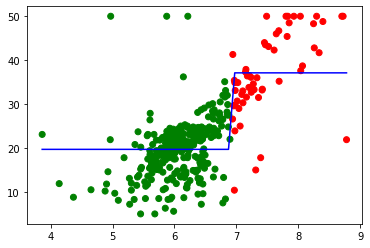

In [99]:
x = np.linspace(column.min(), column.max())
plt.plot(x, (x < t)*labels[0] + (x >= t)*labels[-1], c='b', label=str(model))
plt.scatter(column, y_train, c=np.array(['r','g'])[(column < t).astype(int)])
plt.legend()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [101]:
from sklearn.model_selection import GridSearchCV

s = GridSearchCV(model, param_grid=dict(max_depth=[1,2,5,10,20], min_samples_split=[1,2,5,10,20,50,100,250]), verbose=10)
s.fit(X,y)
best_model = s.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START max_depth=1, min_samples_split=1...........................
[CV 1/5; 1/40] END max_depth=1, min_samples_split=1;, score=-0.042 total time=   0.1s
[CV 2/5; 1/40] START max_depth=1, min_samples_split=1...........................
[CV 2/5; 1/40] END max_depth=1, min_samples_split=1;, score=0.469 total time=   0.1s
[CV 3/5; 1/40] START max_depth=1, min_samples_split=1...........................
[CV 3/5; 1/40] END max_depth=1, min_samples_split=1;, score=-0.077 total time=   0.1s
[CV 4/5; 1/40] START max_depth=1, min_samples_split=1...........................
[CV 4/5; 1/40] END max_depth=1, min_samples_split=1;, score=-0.027 total time=   0.1s
[CV 5/5; 1/40] START max_depth=1, min_samples_split=1...........................
[CV 5/5; 1/40] END max_depth=1, min_samples_split=1;, score=-1.993 total time=   0.1s
[CV 1/5; 2/40] START max_depth=1, min_samples_split=2...........................
[CV 1/5; 2/40] END max_

[CV 5/5; 10/40] END max_depth=2, min_samples_split=2;, score=-0.550 total time=   0.3s
[CV 1/5; 11/40] START max_depth=2, min_samples_split=5..........................
[CV 1/5; 11/40] END max_depth=2, min_samples_split=5;, score=0.439 total time=   0.2s
[CV 2/5; 11/40] START max_depth=2, min_samples_split=5..........................
[CV 2/5; 11/40] END max_depth=2, min_samples_split=5;, score=0.717 total time=   0.2s
[CV 3/5; 11/40] START max_depth=2, min_samples_split=5..........................
[CV 3/5; 11/40] END max_depth=2, min_samples_split=5;, score=0.265 total time=   0.2s
[CV 4/5; 11/40] START max_depth=2, min_samples_split=5..........................
[CV 4/5; 11/40] END max_depth=2, min_samples_split=5;, score=0.262 total time=   0.2s
[CV 5/5; 11/40] START max_depth=2, min_samples_split=5..........................
[CV 5/5; 11/40] END max_depth=2, min_samples_split=5;, score=-0.550 total time=   0.2s
[CV 1/5; 12/40] START max_depth=2, min_samples_split=10......................

[CV 4/5; 20/40] END max_depth=5, min_samples_split=10;, score=0.436 total time=   0.7s
[CV 5/5; 20/40] START max_depth=5, min_samples_split=10.........................
[CV 5/5; 20/40] END max_depth=5, min_samples_split=10;, score=-0.620 total time=   0.8s
[CV 1/5; 21/40] START max_depth=5, min_samples_split=20.........................
[CV 1/5; 21/40] END max_depth=5, min_samples_split=20;, score=0.667 total time=   0.7s
[CV 2/5; 21/40] START max_depth=5, min_samples_split=20.........................
[CV 2/5; 21/40] END max_depth=5, min_samples_split=20;, score=0.610 total time=   0.7s
[CV 3/5; 21/40] START max_depth=5, min_samples_split=20.........................
[CV 3/5; 21/40] END max_depth=5, min_samples_split=20;, score=0.579 total time=   0.7s
[CV 4/5; 21/40] START max_depth=5, min_samples_split=20.........................
[CV 4/5; 21/40] END max_depth=5, min_samples_split=20;, score=0.444 total time=   0.7s
[CV 5/5; 21/40] START max_depth=5, min_samples_split=20.................

[CV 3/5; 30/40] END max_depth=10, min_samples_split=50;, score=0.544 total time=   0.8s
[CV 4/5; 30/40] START max_depth=10, min_samples_split=50........................
[CV 4/5; 30/40] END max_depth=10, min_samples_split=50;, score=0.376 total time=   0.7s
[CV 5/5; 30/40] START max_depth=10, min_samples_split=50........................
[CV 5/5; 30/40] END max_depth=10, min_samples_split=50;, score=-0.742 total time=   0.7s
[CV 1/5; 31/40] START max_depth=10, min_samples_split=100.......................
[CV 1/5; 31/40] END max_depth=10, min_samples_split=100;, score=0.668 total time=   0.5s
[CV 2/5; 31/40] START max_depth=10, min_samples_split=100.......................
[CV 2/5; 31/40] END max_depth=10, min_samples_split=100;, score=0.718 total time=   0.4s
[CV 3/5; 31/40] START max_depth=10, min_samples_split=100.......................
[CV 3/5; 31/40] END max_depth=10, min_samples_split=100;, score=0.563 total time=   0.6s
[CV 4/5; 31/40] START max_depth=10, min_samples_split=100......

[CV 2/5; 40/40] END max_depth=20, min_samples_split=250;, score=0.469 total time=   0.1s
[CV 3/5; 40/40] START max_depth=20, min_samples_split=250.......................
[CV 3/5; 40/40] END max_depth=20, min_samples_split=250;, score=-0.001 total time=   0.2s
[CV 4/5; 40/40] START max_depth=20, min_samples_split=250.......................
[CV 4/5; 40/40] END max_depth=20, min_samples_split=250;, score=0.260 total time=   0.2s
[CV 5/5; 40/40] START max_depth=20, min_samples_split=250.......................
[CV 5/5; 40/40] END max_depth=20, min_samples_split=250;, score=-1.122 total time=   0.2s


In [104]:
s.best_params_

{'max_depth': 5, 'min_samples_split': 10}

In [244]:
from sklearn.metrics import mean_squared_error
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

5.194368464056595

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [31]:
import warnings
warnings.filterwarnings('ignore')

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    all_pred = np.full((n_iter, y.shape[0]), np.nan)
    index = np.arange(y.shape[0])
    
    for i in range(n_iter):
        x_index = np.random.choice(index, size=len(index), replace=True)
        # z_index = set(index) - set(x_index)
        z_index = np.setdiff1d(index, x_index)
        estimator.fit(x[x_index], y[x_index])
        all_pred[i][z_index] = estimator.predict(x[z_index])
        
    avg_pred = np.nanmean(all_pred, axis=0)
    bias2 = np.nanmean((avg_pred - y)**2)
    variance = np.nanmean((avg_pred - all_pred)**2)
    return bias2, variance

In [243]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(17.284772268339367, 9.783479691158625)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [247]:
depths=np.arange(1,16)
bias, var = [], []

for depth in depths:
    estimator = MyDecisionTreeRegressor(max_depth=depth, min_samples_split=5)
    bias_, var_ = get_bias_variance(estimator, X, y, 100)
    bias.append(bias_)
    var.append(var_)

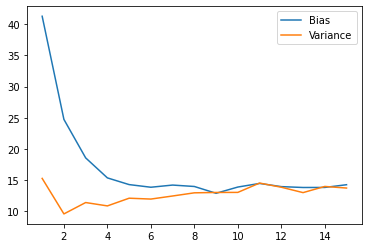

In [248]:
plt.plot(depths, bias, label='Bias')
plt.plot(depths, var, label='Variance')
plt.legend(loc='best')

Looks like the more nodes the model has, the higher the variance and the lower the bias. This corresponds to what was said on lectures and seminars, adding more complexity increases the variance and decreases the bias. So with higher values of max_depth the model is better at predicting features from the training set, but it's more complex, which means that a small change in the input can change the prediction a lot (variance is high).

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

model = MyDecisionTreeRegressor(max_depth=5)
bagging = BaggingRegressor(MyDecisionTreeRegressor(max_depth=5))

bagging_metrics = get_bias_variance(bagging, X, y, 10)
model_metrics = get_bias_variance(model, X, y, 10)

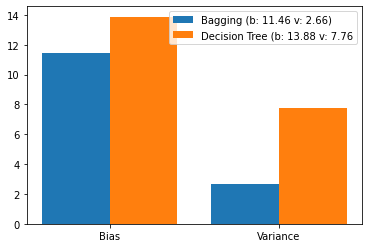

In [78]:
x = np.arange(2)  
_, ax = plt.subplots()
ax.bar(x - 0.2, bagging_metrics, 0.4, 
       label=f'Bagging (b: {bagging_metrics[0]:.2f} v: {bagging_metrics[1]:.2f})')
ax.bar(x + 0.2, model_metrics, 0.4, 
       label=f'Decision Tree (b: {model_metrics[0]:.2f} v: {model_metrics[1]:.2f}')
ax.set_xticks(x)
ax.set_xticklabels(['Bias', 'Variance'])
ax.legend()

1. Bagging should not affect bias but should reduce the variance given that the selected models are not highly correlated.

2. Variance is much lower for bagging, but bias is a little higher for the bare model.

3. Yes, the results do align with the theory (Although the bias has also dropped slightly for some reason), it seems like the models that were chosen by BaggingRegressor are not very correlated, so the variance is about 3 times less for the bagging model. 

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [215]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

0. The column 'TBG' is literally empty, so I think it's pretty safe to drop it

In [216]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

Let's also drop TBG_measured and hypopituitary as they have 0 and 1 true values, and the rest are false 

In [217]:
# Categorical value counts
for col in X[X.columns[X.dtypes.eq('object')]].columns:
    print(X[col].value_counts(), end='\n\n')

F    2480
M    1142
Name: sex, dtype: int64

f    3308
t     464
Name: on_thyroxine, dtype: int64

f    3722
t      50
Name: query_on_thyroxine, dtype: int64

f    3729
t      43
Name: on_antithyroid_medication, dtype: int64

f    3625
t     147
Name: sick, dtype: int64

f    3719
t      53
Name: pregnant, dtype: int64

f    3719
t      53
Name: thyroid_surgery, dtype: int64

f    3713
t      59
Name: I131_treatment, dtype: int64

f    3538
t     234
Name: query_hypothyroid, dtype: int64

f    3535
t     237
Name: query_hyperthyroid, dtype: int64

f    3754
t      18
Name: lithium, dtype: int64

f    3738
t      34
Name: goitre, dtype: int64

f    3676
t      96
Name: tumor, dtype: int64

f    3771
t       1
Name: hypopituitary, dtype: int64

f    3588
t     184
Name: psych, dtype: int64

t    3403
f     369
Name: TSH_measured, dtype: int64

t    3003
f     769
Name: T3_measured, dtype: int64

t    3541
f     231
Name: TT4_measured, dtype: int64

t    3385
f     387
Name: T4U_measured,

In [218]:
X = X.drop(columns=['TBG', 'TBG_measured', 'hypopituitary'])
X.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,1.30,t,2.5,t,125.0,t,1.14,t,109.0,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,4.10,t,2.0,t,102.0,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,0.98,f,NaN,t,109.0,t,0.91,t,120.0,other
3,70.0,F,t,f,f,f,f,f,f,f,...,0.16,t,1.9,t,175.0,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,0.72,t,1.2,t,61.0,t,0.87,t,70.0,SVI


In [219]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [220]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

column_transformer = ColumnTransformer([
    ('categorical', make_pipeline( 
                              SimpleImputer(strategy='most_frequent'), 
                              OneHotEncoder(drop='first')), 
     X.columns[X.dtypes.eq('object')]),
    ('fillna', make_pipeline(
        SimpleImputer(),
        # otherwise svc gives a really bad score 
        StandardScaler()),
     X.columns[X.dtypes.eq('float64')]),
], remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

# PS why did we transform it after splitting, if the next task envolves using a specific splitting
# method, so we need to transform the whole dataset?

In [221]:
X = column_transformer.fit_transform(X)

### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

Since we're trying to predict whether or not a patient has thyroid disease, it makes sense for us to predict as much true positive cases as possible, as false positives are far less dangerous then false negatives. In general, our metric should depend on what type of treatment we should give to that patient, as it might be dangerous for a healthy person. But ultimately, most treatments are disgned to be as safe as possible, so it should not be a big issue if we give some medicine a healthy person, especially if the downside is that we let a deadly disease go undiagnosed. This means we should use Recall as our metric.

Let's use straified shuffle split for cross-validation, as it reduces class inbalance desparity between the training set and the testing set. (maybe we don't need to shuffle, but it does not hurt to do so).

In [222]:
def get_bias_variance_classif(estimator, x, y, n_iter):
    all_pred = np.full((n_iter, y.shape[0]), np.nan)
    index = np.arange(y.shape[0])
    
    for i in range(n_iter):
        x_index = np.random.choice(index, size=len(index), replace=True)
        z_index = np.setdiff1d(index, x_index)
        estimator.fit(x[x_index], y[x_index])
        all_pred[i][z_index] = estimator.predict_proba(x[z_index])[:,1]
        
    avg_pred = np.nanmean(all_pred, axis=0)
    bias2 = np.nanmean((avg_pred - y)**2)
    variance = np.nanmean((avg_pred - all_pred)**2)
    return bias2, variance

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score

models = [
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    SVC(probability=True),
    LogisticRegression()
]

def get_scores(model, X, y, n_iter=30):
    splitter = StratifiedShuffleSplit(random_state=342)
    scores = []
    for train_index, test_index in splitter.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        bias, variance = get_bias_variance_classif(model, X_train, y_train, n_iter)
        y_pred = model.predict(X_test)
        scores.append([bias, variance, recall_score(y_test, y_pred)])
    return np.array(scores).mean(axis=0)

for model in models:
    bias, variance, recall = get_scores(model, X, y, 30)
    print(f"{str(model)[:-2]} model: ", end="")
    print(f"Bias: {100*bias:.2f}e-2, Variance: {100*variance:.2f}e-2, recall: {recall:.2f}")

GradientBoostingClassifier model: Bias: 1.02e-2, Variance: 0.16e-2, recall: 0.86


Seems like SVC and Logistic Regression are underfitting. The bias scores for these models is pretty high. (makes sense, they're linear, after all)

Other models are better at predicting: the bias is lower.

The Decision tree had the highest variance of 0.0074 and it also had the best results for the recall score - 0.87. Clearly, this model is overfitting. 

RandomForest is the least overfitted with a variance of 0.0006

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [188]:
!pip install xgboost

In [189]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
scores = []
params = {
    'n_estimators': np.array(np.logspace(2,3,10), dtype=int),
    'learning_rate': np.logspace(-5,0,10),
    'max_depth': np.array(np.logspace(0.7, 3, 10), dtype=int),
    'eval_metric': ['auc', 'aucpr', 'logloss']
}
rs = RandomizedSearchCV(XGBClassifier(), params, scoring='recall')
rs.fit(X, y)
rs.best_params_

{'n_estimators': 599,
 'max_depth': 52,
 'learning_rate': 0.021544346900318846,
 'eval_metric': 'logloss'}

In [190]:
from xgboost import XGBClassifier
model = XGBClassifier(eval_metric='logloss', n_estimators=200, learning_rate=2e-2, max_depth=50)
for metric, val in zip('Bias Variance Recall'.split(), get_scores(model, X, y, n_iter=30)):
    print(f"{metric} score: {val}")

Bias score: 0.008341487065523175
Variance score: 0.0017663857368206022
Recall score: 0.8913043478260869


The bias score for this model is had the smallest value overall, as well as recall score. The results have imporved after some paramter tuning.

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [191]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

estimator_list = list(zip('GradBoost, RandomForest, XGB'.split(', '), [
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    XGBClassifier(eval_metric='logloss', n_estimators=200, learning_rate=2e-2, max_depth=30)
]))

models = [
    BaggingClassifier(DecisionTreeClassifier()),
    BaggingClassifier(GradientBoostingClassifier(n_estimators=250)),
    VotingClassifier(estimator_list, voting='soft'),
    StackingClassifier(estimator_list, LogisticRegression()),
    StackingClassifier(estimator_list, GradientBoostingClassifier()),
]
                      
names = 'Bagging DecTree, Bagging GradBoost, Voting, Stacking Logres, Staking GradBoost'
for name, model in zip(names.split(', '), models):
    bias, variance, recall = get_scores(model, X, y)
    print(f"{name} model: ", end="")
    print(f"Bias: {100*bias:.2f}e-2, Variance: {100*variance:.2f}e-2, recall: {recall:.2f}")

Bagging DecTree model: Bias: 0.91e-2, Variance: 0.24e-2, recall: 0.86
Bagging GradBoost model: Bias: 1.01e-2, Variance: 0.15e-2, recall: 0.84
Voting model: Bias: 0.93e-2, Variance: 0.08e-2, recall: 0.83
Stacking Logres model: Bias: 0.94e-2, Variance: 0.15e-2, recall: 0.83
Staking GradBoost model: Bias: 0.91e-2, Variance: 0.47e-2, recall: 0.86


Same gradient boost with no bagging:

In [194]:
bias, variance, recall = get_scores(GradientBoostingClassifier(n_estimators=250), X, y, 30)
print(f"GradBoost(n=250) model: ", end="")
print(f"Bias: {100*bias:.2f}e-2, Variance: {100*variance:.2f}e-2, recall: {recall:.2f}")

GradBoost(n=250) model: Bias: 0.95e-2, Variance: 0.24e-2, recall: 0.84


1. XGBClassifier model produced the best results - 0.89
2. Yes, but only a little bit less variance: 0.0015 vs 0.0024
3. Both models take multiple estimators and make a prediction for every one of them. The difference is that the voting model combines these predictions with a certain weight, and the stacking model stacks the output of these models together and then uses another model to make the final prediction.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

Bagging with the Gradient Boost model produced the best results - 0.89